In [1]:
!python --version

Python 3.10.13


In [2]:
# !pip install tensorflow

In [3]:
# import system libs
import os
import time

# import data handling tools
import cv2
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential, model_from_json
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras import regularizers

from tensorflow.keras.layers import Flatten, Dense, Activation
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

2024-05-14 15:22:37.805027: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-14 15:22:37.805154: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-14 15:22:37.935739: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.15.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13709314401258197559
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 16274030592
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12290397624602353781
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
xla_global_id: 416903419
]


In [6]:
# define model parameters
img_size = (224, 224)
channels = 3 # either BGR or Grayscale
img_shape = (img_size[0], img_size[1], channels)
color = 'rgb'
seed = 123


batch_size = 32
lr = 3e-4
epochs = 100

### Data Loading

In [7]:
class EyeDiseaseDataset:
    def __init__(self, data_dir):
        self.data_dir = data_dir
        
    def get_data_paths(self):
        file_paths = []
        labels = []
        for folder_name in os.listdir(self.data_dir):
            if folder_name in ['cataract', 'diabetic_retinopathy']: # 'ARMD','glaucoma'
                continue
            folder_path = os.path.join(self.data_dir, folder_name)
            file_list = os.listdir(folder_path)
            for file in file_list:
                file_path = os.path.join(folder_path, file)
                file_paths.append(file_path)
                labels.append(folder_name)

        return file_paths, labels
    
    def create_dataframe(self, file_paths, labels):
        file_series = pd.Series(file_paths, name='file_paths')
        label_series = pd.Series(labels, name='labels')
        
        return pd.concat([file_series, label_series], axis=1)
    
    def split_data(self):
        file_paths, labels = self.get_data_paths()
        df = self.create_dataframe(file_paths, labels)
        
        # train dataframe
        strat = df['labels']
        train_df, dummy_df = train_test_split(df,
                                             train_size=0.8,
                                             shuffle=True,
                                             random_state=seed,
                                             stratify=strat)
        
        # valid and test dataframe
        strat = dummy_df['labels']
        valid_df, test_df = train_test_split(dummy_df,
                                            train_size=0.5,
                                            shuffle=True,
                                            random_state=seed,
                                            stratify=strat)
        
        return train_df, valid_df, test_df
        
        

In [8]:
data_dir='/kaggle/input/ocular-disease/dataset/dataset'
data = EyeDiseaseDataset(data_dir)

In [9]:
# file_paths, labels = data.get_data_paths()
# file_paths[:3], labels[:3]

In [10]:
# df = data.create_dataframe(file_paths, labels)
# df.head()

In [11]:
train_df, valid_df, test_df = data.split_data()
train_df.shape, valid_df.shape, test_df.shape

((2073, 2), (259, 2), (260, 2))

In [12]:
train_df.labels.value_counts()

labels
normal      859
glaucoma    805
ARMD        409
Name: count, dtype: int64

In [13]:
valid_df.labels.value_counts()

labels
normal      107
glaucoma    101
ARMD         51
Name: count, dtype: int64

In [14]:
test_df.labels.value_counts()

labels
normal      108
glaucoma    101
ARMD         51
Name: count, dtype: int64

In [15]:
def create_data_gen(train_df, valid_df, test_df, batch_size=16):

    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=30,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=[0.5, 1.5])

    valid_test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
          
    train_generator = train_datagen.flow_from_dataframe(
              train_df,
              x_col='file_paths',
              y_col='labels',
              target_size=img_size,
              color_mode=color,
              batch_size=batch_size,
              shuffle=True,
              class_mode='categorical'
          )
   
    print("Shape of augmented training images:", train_generator.image_shape)
          
    valid_generator = valid_test_datagen.flow_from_dataframe(
              valid_df,
              x_col='file_paths',
              y_col='labels',
              target_size=img_size,
              color_mode=color,
              batch_size=batch_size,
              shuffle=True,
              class_mode='categorical'
          )
         
    print("Shape of validation images:", valid_generator.image_shape)
          
    test_generator = valid_test_datagen.flow_from_dataframe(
              test_df,
              x_col='file_paths',
              y_col='labels',
              target_size=img_size,
              color_mode=color,
              batch_size=batch_size,
              shuffle=False,
              class_mode='categorical'
          )
          
    print("Shape of test images:", test_generator.image_shape)
          
    return train_generator, valid_generator, test_generator

In [16]:
train_generator, valid_generator, test_generator = create_data_gen(train_df, valid_df, test_df, batch_size=batch_size)

Found 2073 validated image filenames belonging to 3 classes.
Shape of augmented training images: (224, 224, 3)
Found 259 validated image filenames belonging to 3 classes.
Shape of validation images: (224, 224, 3)
Found 260 validated image filenames belonging to 3 classes.
Shape of test images: (224, 224, 3)


In [17]:
images, labels = next(train_generator)
len(images), len(labels)

(32, 32)

In [18]:
# np.min(images[0]), np.max(images[0])

In [19]:
# images[0]

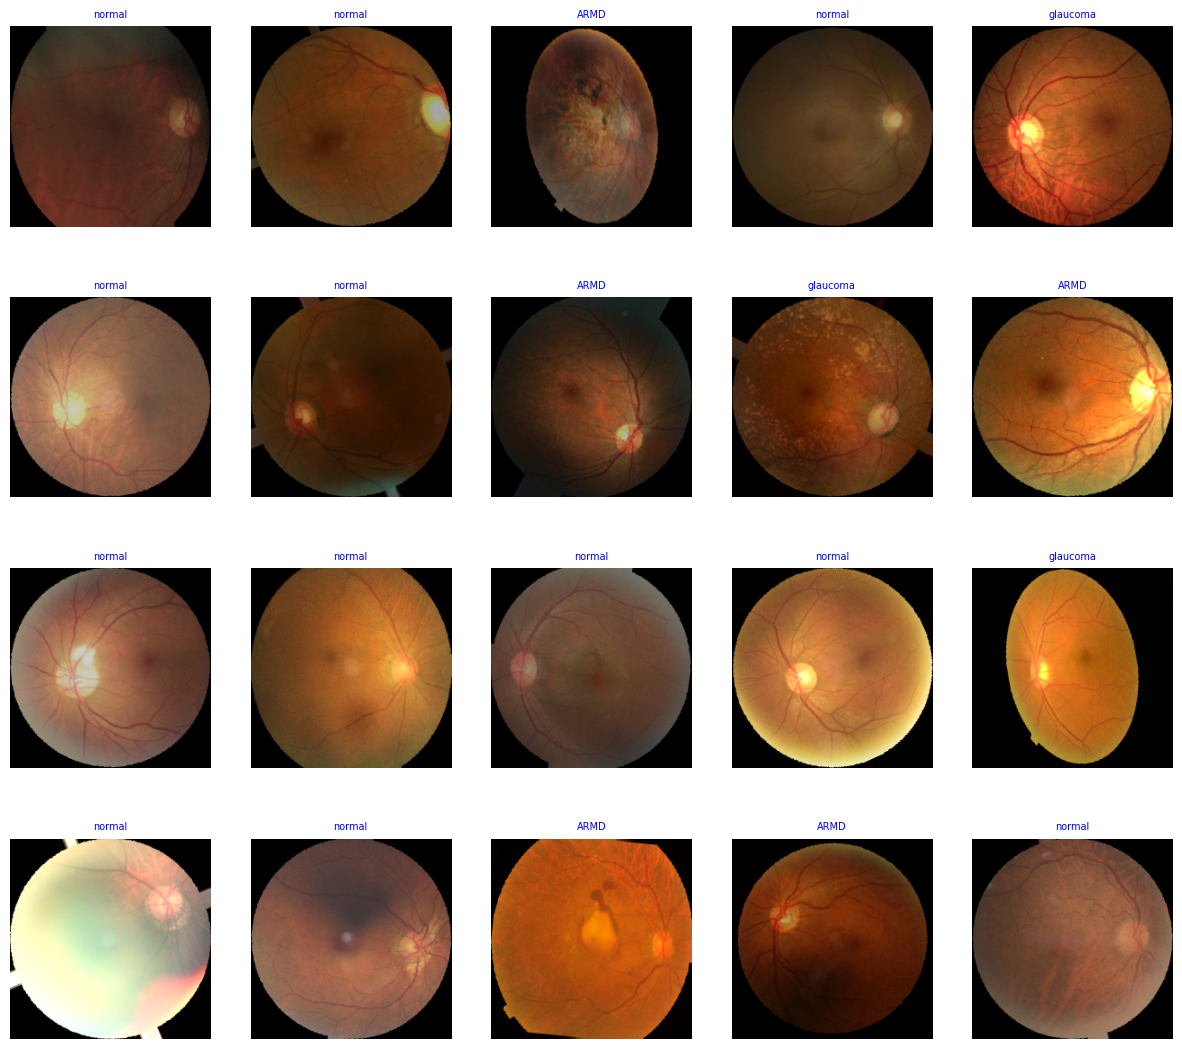

In [20]:
def show_images(gen):  
    g_dict = gen.class_indices        # defines dictionary {'class': index}
    classes = list(g_dict.keys())     # defines list of dictionary's kays (classes), classes names : string
    images, labels = next(gen)        # get a batch size samples from the generator
    length = len(labels)       
    sample = min(length, 20)
    
    plt.figure(figsize= (15, 17))
    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255
        plt.imshow(image)
        index = np.argmax(labels[i])  
        class_name = classes[index]  
        plt.title(class_name, color='blue', fontsize=7)
        plt.axis('off')
    plt.show()
    
show_images(train_generator)

### Model

In [21]:
def create_model(num_classes, learning_rate):
    # Load the pre-trained EfficientNetB3 model
    base_model = EfficientNetB3(input_shape=img_shape,
                                weights='imagenet', 
                                include_top=False, 
                               )

    # Freeze the layers in the base model
    for layer in base_model.layers:
        layer.trainable = False
    
    # Add additional layers for feature extraction and classification
    x = base_model.output
#     x = Flatten()(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5, seed=seed)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [23]:
num_classes = len(list(train_generator.class_indices.keys()))
model = create_model(num_classes, learning_rate=lr)
model.summary()

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 40)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        960 │ block1a_se_excit

 Total params: 11,572,018 (44.14 MB)

 Trainable params: 788,483 (3.01 MB)

 Non-trainable params: 10,783,535 (41.14 MB)

### Callback

In [24]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True
)

# lr_schedule = tf.keras.callbacks.LearningRateScheduler(
#     lambda epoch: 1e-8 * 10**(epoch/20)
# )

lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    min_lr=0.0001
)

### Train

In [25]:
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=valid_generator,
    verbose=1,
    callbacks=[early_stopping, lr_schedule]
    )

Epoch 1/100
 2/65 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.4688 - loss: 1.0672    

I0000 00:00:1715700249.267328      73 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


65/65 ━━━━━━━━━━━━━━━━━━━━ 177s 2s/step - accuracy: 0.5958 - loss: 0.8417 - val_accuracy: 0.7027 - val_loss: 0.6280 - learning_rate: 3.0000e-04
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 39s 546ms/step - accuracy: 0.7763 - loss: 0.5635 - val_accuracy: 0.7799 - val_loss: 0.5063 - learning_rate: 3.0000e-04
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 39s 517ms/step - accuracy: 0.8007 - loss: 0.5130 - val_accuracy: 0.8069 - val_loss: 0.4850 - learning_rate: 3.0000e-04
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 41s 542ms/step - accuracy: 0.7903 - loss: 0.4985 - val_accuracy: 0.8108 - val_loss: 0.4579 - learning_rate: 3.0000e-04
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 39s 531ms/step - accuracy: 0.8231 - loss: 0.4558 - val_accuracy: 0.8378 - val_loss: 0.4227 - learning_rate: 3.0000e-04
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 38s 527ms/step - accuracy: 0.8012 - loss: 0.4767 - val_accuracy: 0.7761 - val_loss: 0.5370 - learning_rate: 3.0000e-04
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 38s 526ms/step - accuracy: 

Training Accuracy: 0.8842257857322693
Validation Accuracy: 0.8532818555831909


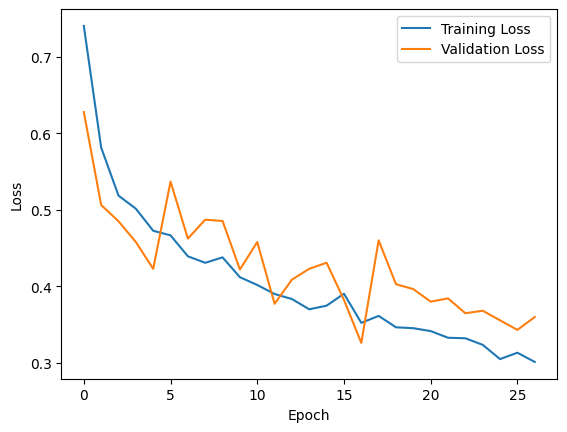

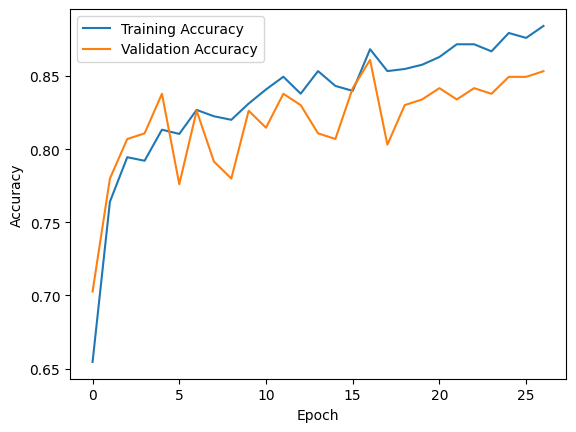

In [26]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
print("Training Accuracy:", train_accuracy[-1])
print("Validation Accuracy:", val_accuracy[-1])
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Evaluate

In [27]:
ts_length = len(test_df)
test_steps = ts_length // batch_size
# test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
# test_steps = ts_length // test_batch_size


train_score = model.evaluate(train_generator, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_generator, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_generator, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 601ms/step - accuracy: 0.8828 - loss: 0.3354
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 245ms/step - accuracy: 0.8748 - loss: 0.3072
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 564ms/step - accuracy: 0.8297 - loss: 0.4196
Train Loss:  0.33971506357192993
Train Accuracy:  0.890625
--------------------
Validation Loss:  0.32926470041275024
Validation Accuracy:  0.859375
--------------------
Test Loss:  0.3931558132171631
Test Accuracy:  0.83984375


### Testing

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


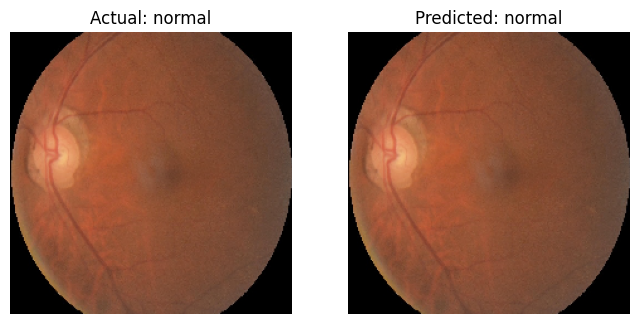

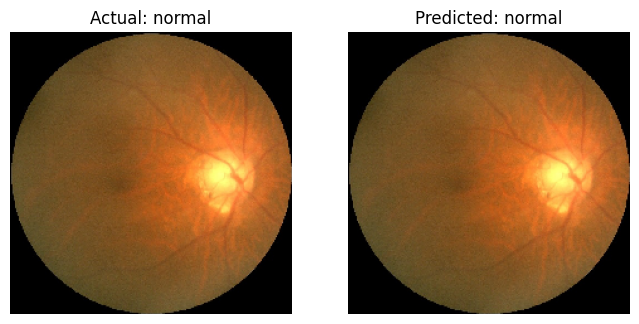

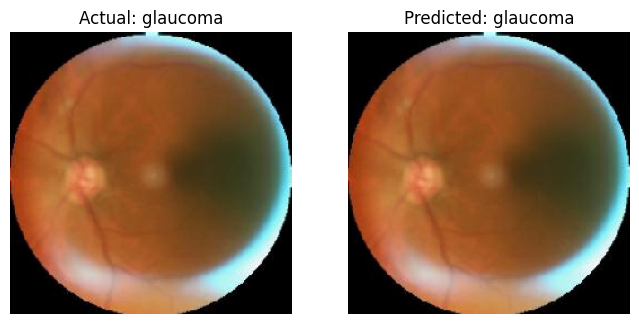

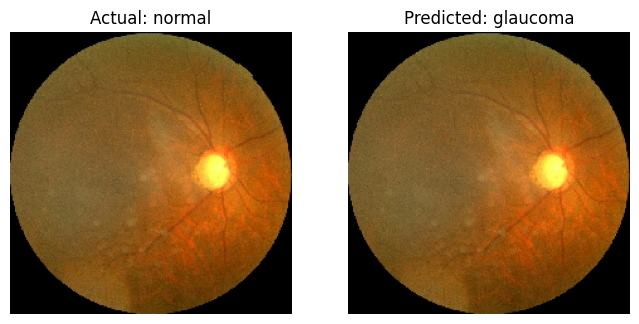

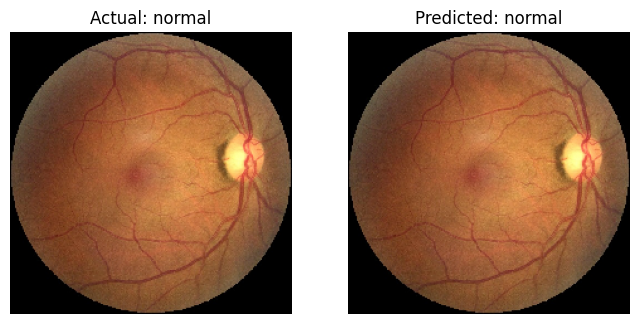

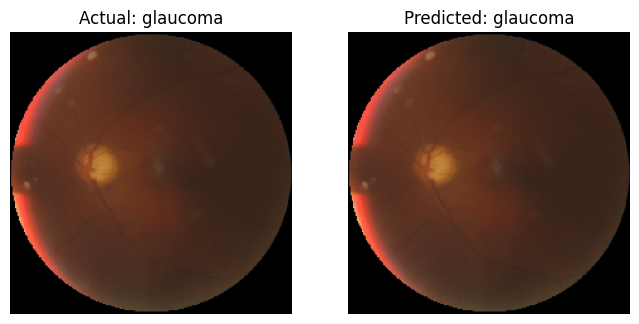

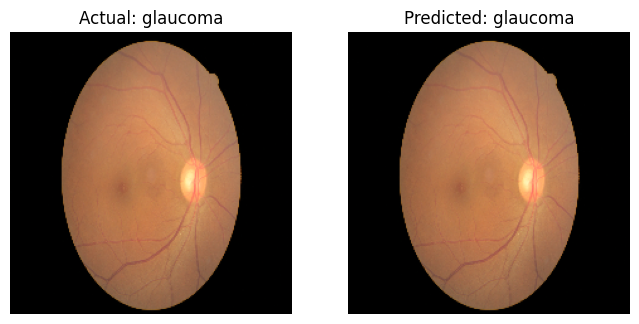

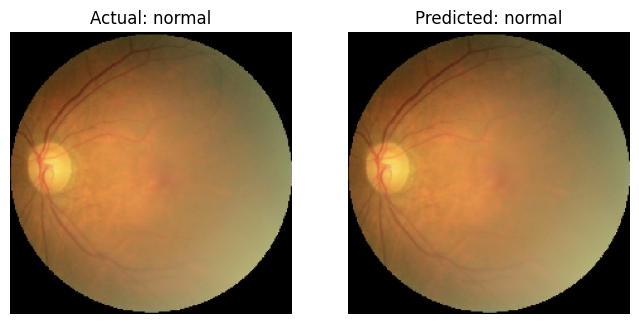

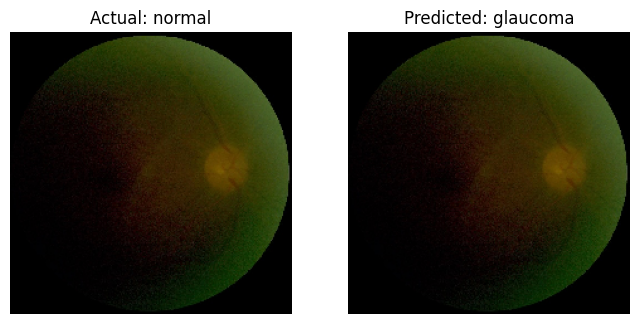

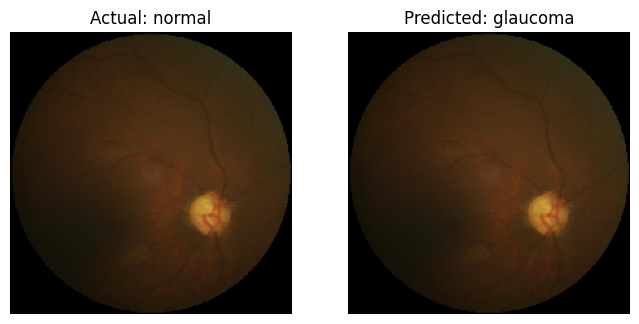

In [28]:
def plot_actual_vs_predicted(model, test_data, num_samples=10):
    # Get a batch of test data
    test_images, test_labels = next(iter(test_data))

    predictions = model.predict(test_images)

    class_labels = list(train_generator.class_indices.keys())

    sample_indices = np.random.choice(range(len(test_images)), num_samples, replace=False)
    # Plot the images with actual and predicted labels
    for i in sample_indices:
        actual_label = class_labels[np.argmax(test_labels[i])]
        predicted_label = class_labels[np.argmax(predictions[i])]
        plt.figure(figsize=(8, 4))
        # Actual Image
        plt.subplot(1, 2, 1)
        plt.imshow(test_images[i].astype(np.uint8))  
        plt.title(f'Actual: {actual_label}')
        plt.axis('off')
        # Predicted Image
        plt.subplot(1, 2, 2)
        plt.imshow(test_images[i].astype(np.uint8))  
        plt.title(f'Predicted: {predicted_label}')
        plt.axis('off')
        plt.show()
        
plot_actual_vs_predicted(model, test_generator)

In [29]:
preds = model.predict(test_generator)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

9/9 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step
[2 1 1 2 1 0 0 2 2 1 1 2 2 1 1 1 2 2 2 1 2 1 1 2 2 2 0 2 1 2 1 1 2 2 2 2 2
 1 1 1 2 1 2 1 1 1 2 1 1 2 2 0 1 1 2 2 1 1 2 2 0 1 1 2 2 2 2 2 0 2 2 2 0 1
 2 2 1 2 1 0 2 2 1 1 0 1 1 1 1 1 0 1 1 0 2 0 2 0 1 2 2 0 0 2 0 1 1 2 1 1 1
 2 0 0 0 0 1 0 1 1 2 1 2 2 1 0 0 1 1 0 1 2 2 1 0 2 1 1 0 1 1 0 1 1 0 1 1 1
 1 0 1 2 2 0 0 0 1 1 1 0 2 0 1 1 1 2 1 2 2 1 1 1 1 2 2 2 2 1 2 1 0 0 1 2 1
 2 0 1 2 2 2 0 1 0 2 2 2 1 1 0 1 1 1 0 1 1 2 0 1 2 2 0 2 1 0 2 2 2 1 1 1 1
 2 2 0 2 0 1 1 2 0 2 0 2 0 2 0 1 2 2 1 1 1 0 1 2 1 0 0 2 1 2 2 2 0 2 1 0 2
 2]


In [30]:
from sklearn.metrics import confusion_matrix, classification_report
import itertools

In [31]:
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
    '''
    This function plot confusion matrix method from sklearn package.
    '''

    plt.figure(figsize= (10, 10))
    plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation= 45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
        print('Normalized Confusion Matrix')

    else:
        print('Confusion Matrix, Without Normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

        plt.tight_layout()
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')

Confusion Matrix, Without Normalization
[[46  3  2]
 [ 6 86  9]
 [ 3 18 87]]
              precision    recall  f1-score   support

        ARMD       0.84      0.90      0.87        51
    glaucoma       0.80      0.85      0.83       101
      normal       0.89      0.81      0.84       108

    accuracy                           0.84       260
   macro avg       0.84      0.85      0.85       260
weighted avg       0.85      0.84      0.84       260



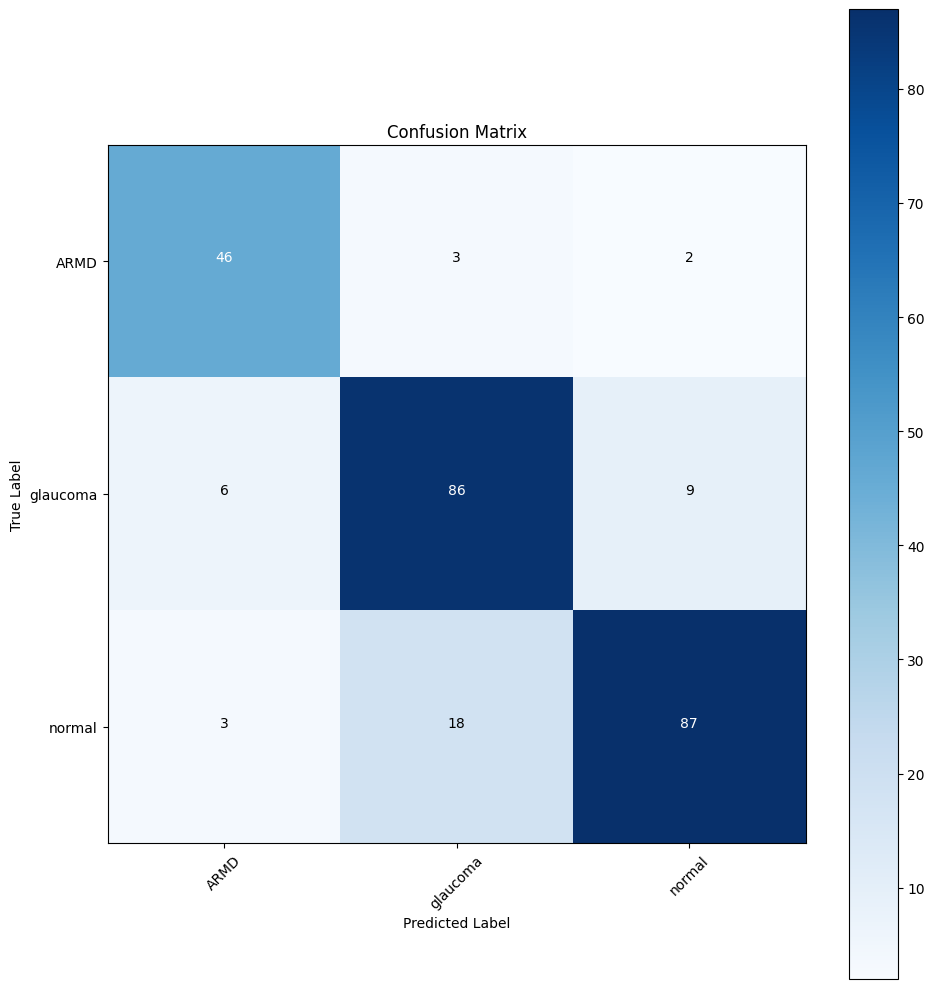

In [32]:
g_dict = test_generator.class_indices
classes = list(g_dict.keys())

# Confusion matrix
conf_matrix = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm=conf_matrix, classes= classes, title = 'Confusion Matrix')

# Classification report
print(classification_report(test_generator.classes, y_pred, target_names= classes))

### Save & Load model

In [33]:
# acc = test_score[1] * 100
# acc

In [34]:
model_name = 'efficientnetb3'
subject = 'eye-diseases-02'
save_path = ''

# Save model
save_id = str(f'{model_name}-{subject}.h5')
model_save_loc = os.path.join(save_path, save_id)
model.save(model_save_loc)
print(f'model was saved as {model_save_loc}')

# Save weights
weight_save_id = str(f'{model_name}-{subject}.weights.h5')
weights_save_loc = os.path.join(save_path, weight_save_id)
model.save_weights(weights_save_loc)
print(f'weights were saved as {weights_save_loc}')

model was saved as efficientnetb3-eye-diseases-02.h5
weights were saved as efficientnetb3-eye-diseases-02.weights.h5


In [35]:
# Save the entire model as a `.keras` zip archive.
zip_id = str(f'{model_name}-{subject}.keras')
model_zip_loc = os.path.join(save_path, zip_id)
model.save(model_zip_loc)
print(f'model was saved as {model_zip_loc}')

model was saved as efficientnetb3-eye-diseases-02.keras


In [36]:
# serialize model to JSON
model_json = model.to_json()
with open("model-02.json", "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights("model-02.weights.h5")
print("Saved model to disk")

Saved model to disk


### Load model

In [37]:
# load json and create model
json_file = open('model-02.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model-02.weights.h5")
print("Loaded model from disk")

Loaded model from disk


In [38]:
# loaded_model.summary()

In [39]:
# Load saved_model
# new_model = tf.saved_model.load('./saved_model')
# new_model

In [40]:
# Load .h5 model
# new_model = tf.keras.models.load_model(model_save_loc)
# new_model.summary()

In [41]:
# new_model = tf.keras.models.load_model(model_zip_loc)
# new_model.summary()

In [42]:
ts_length = len(test_df)
test_steps = ts_length // batch_size

train_score = loaded_model.evaluate(train_generator, steps= test_steps, verbose= 1)
valid_score = loaded_model.evaluate(valid_generator, steps= test_steps, verbose= 1)
test_score = loaded_model.evaluate(test_generator, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 507ms/step - accuracy: 0.8141 - loss: 0.5050
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 208ms/step - accuracy: 0.7268 - loss: 0.6201
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 304ms/step - accuracy: 0.6970 - loss: 0.6960
Train Loss:  0.5022876262664795
Train Accuracy:  0.80078125
--------------------
Validation Loss:  0.6026029586791992
Validation Accuracy:  0.7265625
--------------------
Test Loss:  0.6319142580032349
Test Accuracy:  0.72265625


In [43]:
test_images, test_labels = next(iter(test_generator))
test_images[0].shape, test_labels[0]

((224, 224, 3), array([0., 0., 1.], dtype=float32))

In [44]:
list(test_generator.class_indices.keys())

['ARMD', 'glaucoma', 'normal']

In [45]:
# Get the class indices mapping from the generator
class_indices = test_generator.class_indices

# Invert the mapping to get a dictionary of class labels
class_labels = {v: k for k, v in class_indices.items()}
class_labels

{0: 'ARMD', 1: 'glaucoma', 2: 'normal'}

In [46]:
idx = 0
input_data = np.expand_dims(test_images[idx], axis=0)  # Add batch dimension
predictions = loaded_model.predict(input_data)

actual_label = class_labels[np.argmax(test_labels[0])]
predicted_label = class_labels[np.argmax(predictions[0])]

print("Actual: ", actual_label)
print("Prediction: ", predicted_label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
Actual:  normal
Prediction:  normal


In [47]:
# Inference with images path
img_path = "/kaggle/input/ocular-disease/dataset/dataset/ARMD/0_1kIM_10_ARMD.png"
img = tf.keras.utils.load_img(
    img_path, target_size=(img_size[0], img_size[1])
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

img_array.shape

TensorShape([1, 224, 224, 3])

In [48]:
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_labels[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
This image most likely belongs to ARMD with a 56.31 percent confidence.
